In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
import seaborn as sns
#import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
from matplotlib.mlab import griddata
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text,SelectMultiple,FloatRangeSlider
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from IPython.core.display import HTML,Image
from functools import reduce
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve,roc_auc_score,auc,precision_recall_curve,average_precision_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
cd /Users/james/NS_model

/Users/james/NS_model


In [3]:
# setup figure template
figure_template_path = 'bin/'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
# force reload of the module
reload(figure_template)
from figure_template import std_plot,display_dataframe, embed_pdf_figure, embed_pdf_pages
fontlegend = {'family':'Arial',
                  'weight' : 'normal', 
              #'linewidth':0.5,
                  'size' : 6.5*1}

In [4]:
FRB_H15_table = pd.read_table('data/FRB_H15.csv',sep=',',index_col=0).dropna()
frb_index = FRB_H15_table.index
time_arr = np.array([i.split('-') for i in frb_index[5:] ]).astype('int')

select_table = FRB_H15_table.iloc[np.concatenate((np.zeros([5]),(time_arr[:,0] >=2009)&(time_arr[:,2] ==6))).astype('bool')]
nan_ind = np.where(np.isin(np.array(FRB_H15_table.index),np.array(select_table.iloc[np.unique(np.where(select_table=='ND')[0])].index))==1)[0]

select_table.iloc[np.unique(np.where(select_table=='ND')[0])] = np.array(FRB_H15_table.iloc[nan_ind+1])


FRB_H15_table = pd.read_table('data/FRB_H15.csv',sep=',',index_col=0).dropna().iloc[:,:-1]
frb_index = FRB_H15_table.index
time_arr = np.array([i.split('-') for i in frb_index[5:] ]).astype('int')

select_table = FRB_H15_table.iloc[np.concatenate((np.zeros([5]),(time_arr[:,0] >=2002)&(time_arr[:,0] <=2010)&(time_arr[:,2] ==6))).astype('bool')]
nan_ind = np.where(np.isin(np.array(FRB_H15_table.index),np.array(select_table.iloc[np.unique(np.where(select_table=='ND')[0])].index))==1)[0]
if nan_ind.shape[0] >0:
    select_table.iloc[np.unique(np.where(select_table=='ND')[0])] = np.array(FRB_H15_table.iloc[nan_ind+1])



tmp = np.unique(time_arr[:,2],return_counts=1)[1]
plt.plot(tmp)
np.argmax(tmp)

In [5]:
select_table=select_table.astype('float')
revise_columns = np.array([i.split(' ')[7] for i in np.array(select_table.columns)]).astype('str')
select_table.columns = revise_columns
select_arr = np.array(select_table).astype('float')
month_ind = np.array([0,2,5,11,23,35,59,83,119,239,359])
resize_arr = np.zeros([select_arr.shape[0],360])
for i in range((select_arr.shape[0])):
    resize_arr[i] = np.interp(np.arange(360),month_ind,select_arr[i])

In [12]:
month_ind

array([  0,   2,   5,  11,  23,  35,  59,  83, 119, 239, 359])

In [13]:
select_arr[i]

array([0.16, 0.2 , 0.4 , 0.6 , 0.94, 1.37, 1.9 , 2.55, 2.95, 3.82, 3.73])

In [6]:
month_ind

array([  0,   2,   5,  11,  23,  35,  59,  83, 119, 239, 359])

select_arr = np.array(select_table).astype('float')
month_ind = np.array([0,2,5,11,23,35,59,83,119,239])
resize_arr = np.zeros([select_arr.shape[0],240])
for i in range((select_arr.shape[0])):
    resize_arr[i] = np.interp(np.arange(240),month_ind,select_arr[i])

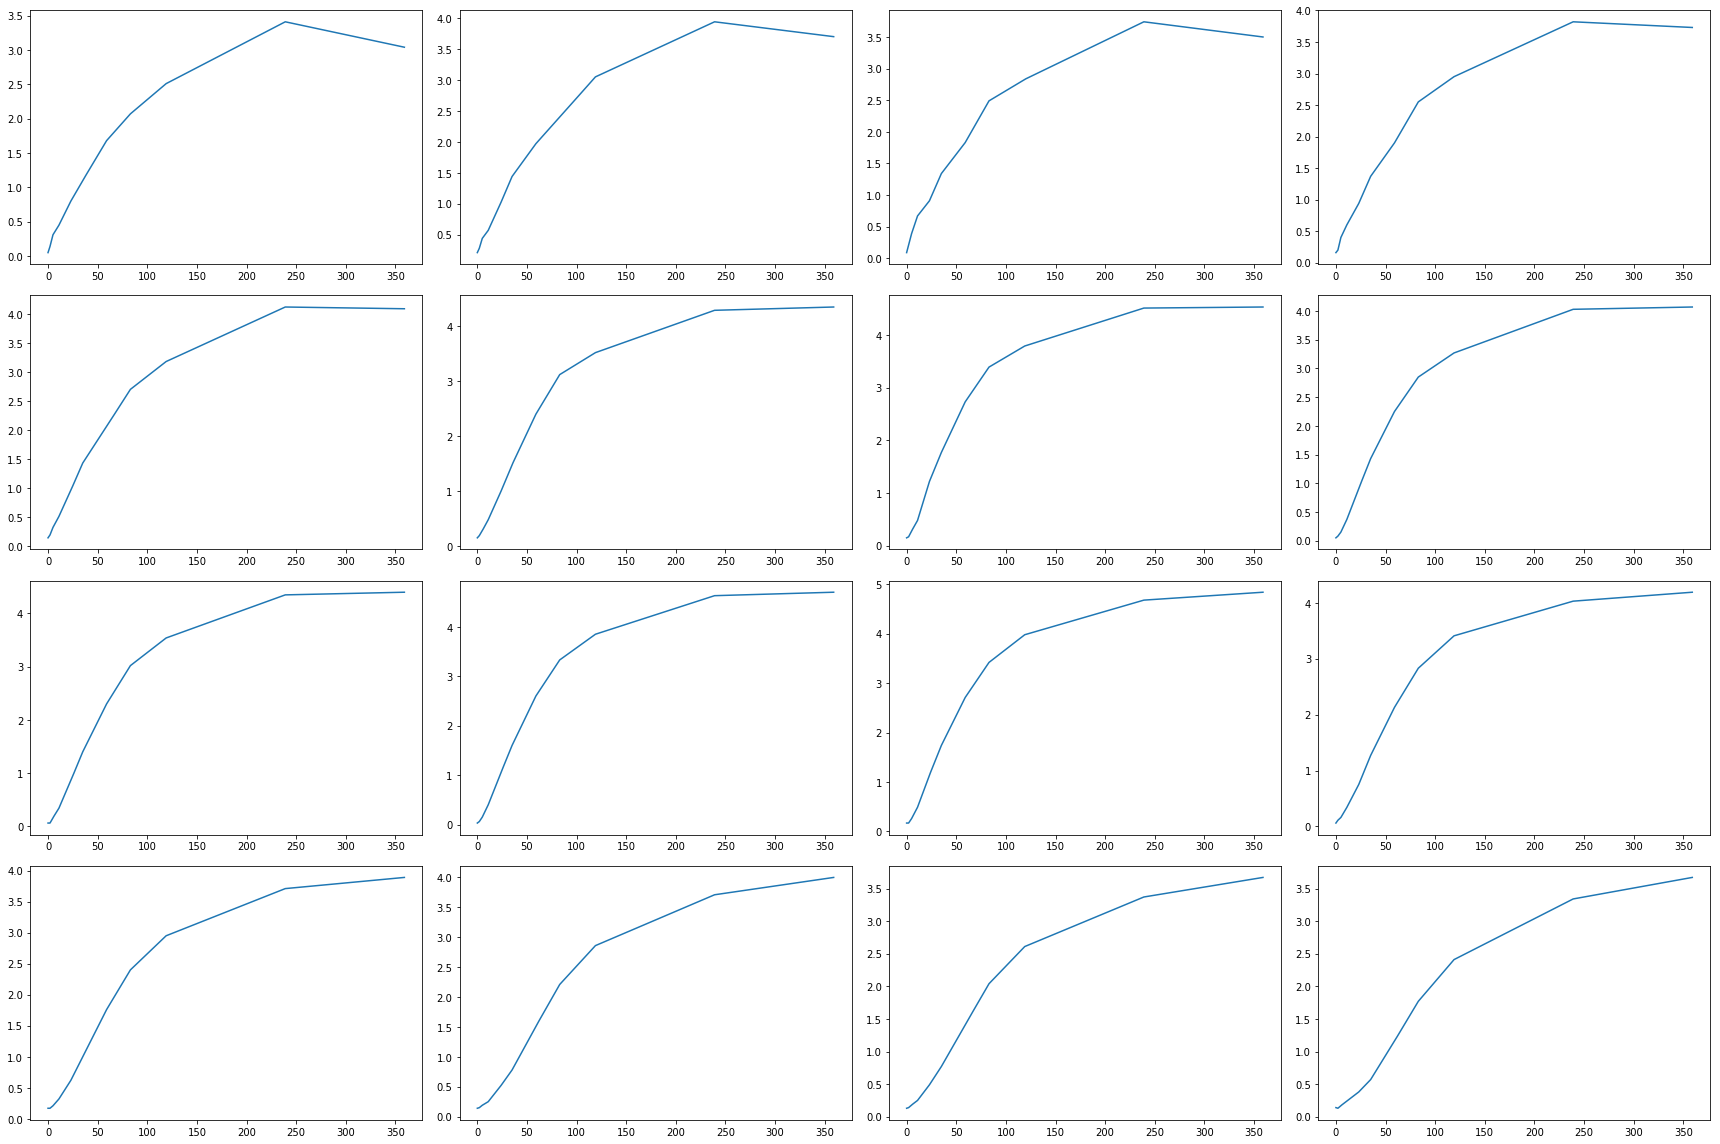

In [7]:
plot_num = 4
fig,ax = plt.subplots(plot_num,4,figsize=(24,4*plot_num))
for i in range(plot_num):
    for j in range(4):
        ax[i,j].plot(resize_arr[i*4+j])
fig.tight_layout()
#embed_pdf_figure()

In [8]:
time_start = 0
time_end = 89
start_point = 30
end_point = 240
Zs = resize_arr[time_start:time_end,start_point:end_point]
Zs = Zs.ravel()
Ys = np.repeat(np.arange(time_start,time_end),end_point-start_point)
Xs= np.repeat(np.arange(start_point,end_point),time_end-time_start).reshape(-1,time_end-time_start).T.ravel()


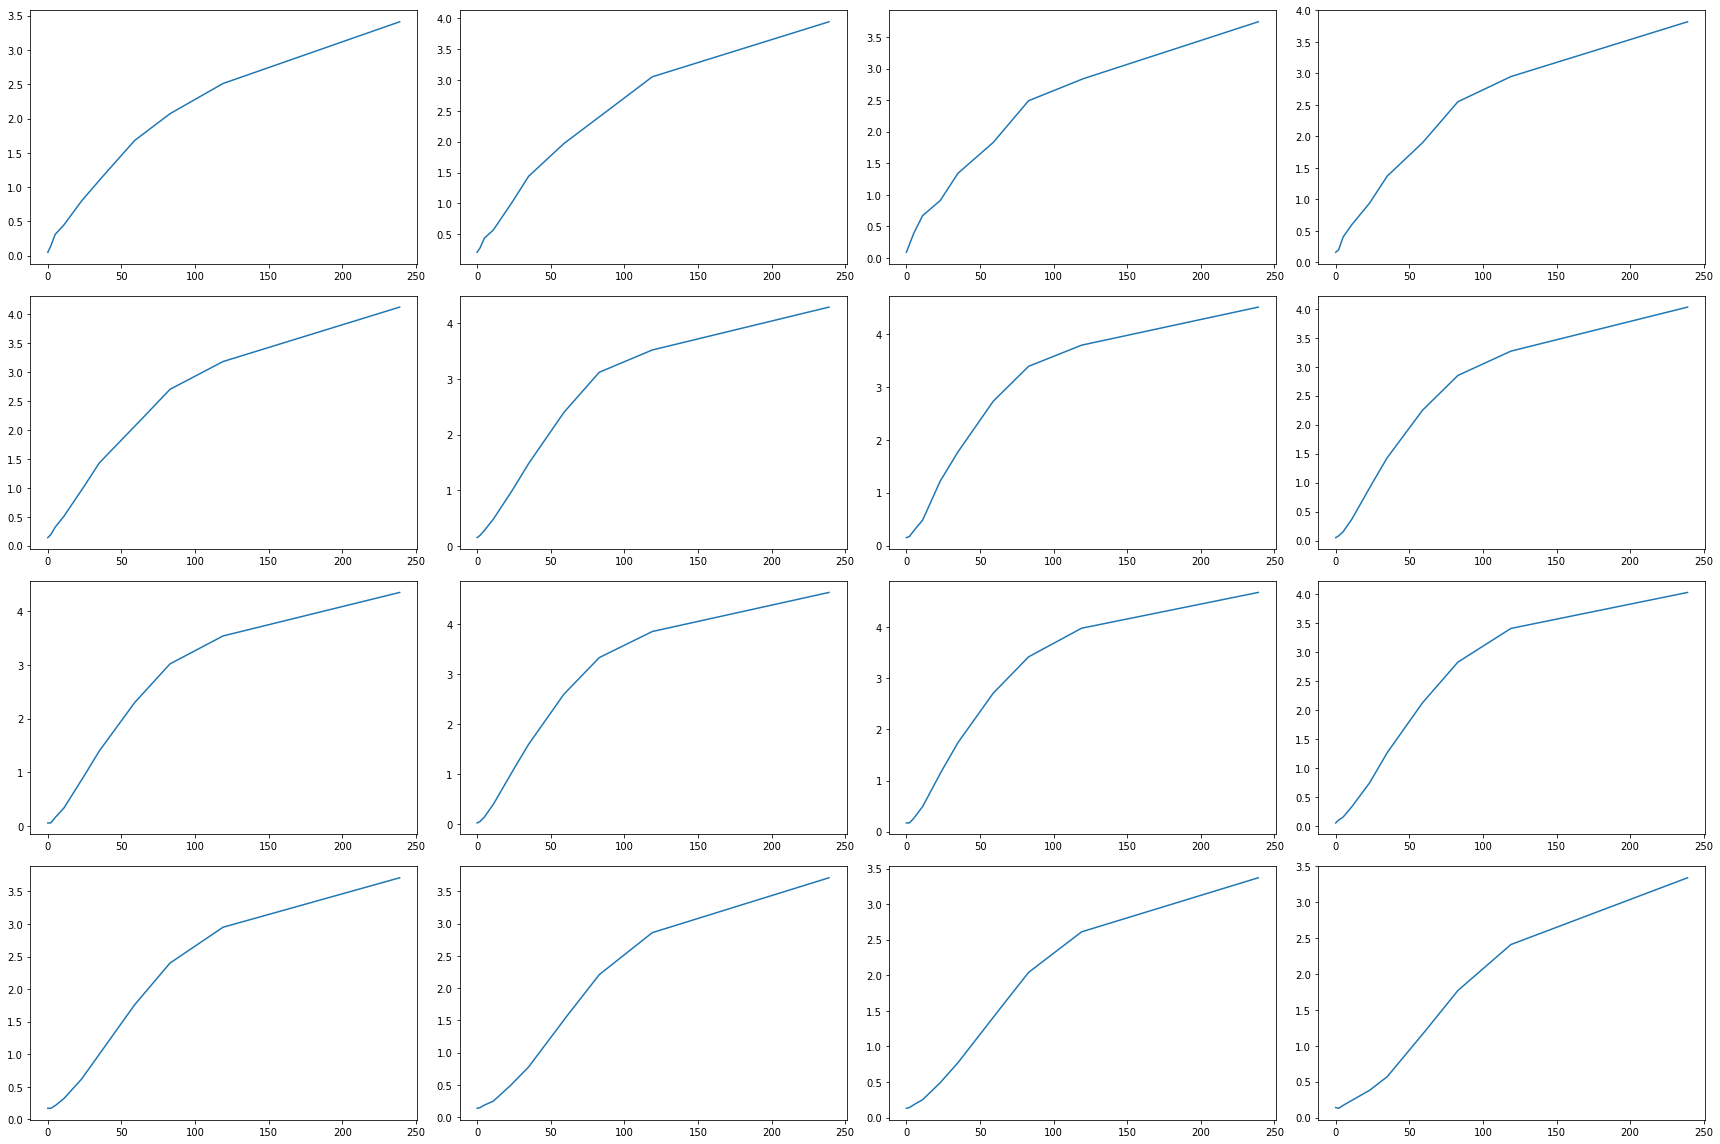

In [9]:
plot_num = 4
fig,ax = plt.subplots(plot_num,4,figsize=(24,4*plot_num))
for i in range(plot_num):
    for j in range(4):
        ax[i,j].plot(resize_arr[time_start:time_end,:end_point][i*4+j])
fig.tight_layout()
#embed_pdf_figure()

In [10]:
# creation of a 2D grid
def plot_3d_grid_surface(width,height,azim,elev,contextind,styind,featureind,savefig):
    fig = plt.figure(figsize=(width,height))
    X = Xs
    Y = Ys
    Z = Zs
    x = X.ravel()
    y = Y.ravel()
    z = Z.ravel()
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    
    ax = Axes3D(fig)
    #ax.scatter3D(x,y,z,c=z,cmap=plt.cm.jet)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=1, antialiased=True,alpha=1) 
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)



    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(azim=azim,elev=elev)  # 50 20
    #ax.set_title('3D surface using feature '+'{:2}'.format(str(featureind)))
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax=std_plot(ax,'month','year','rate','3D plot',fontscale=4,
                xticklabel=np.array([str(i) for i in range(50,250,50)]),
               yticklabel = np.array([str(i) for i in range(2009,2019,2)]))
    fig.tight_layout()
    if savefig=='save':
        #fig.savefig('3D_surface_of_feature_'+'{:2}'.format(str(featureind)))
        fig.savefig('output/3D_surface.eps')
    else:
        plt.show()
interact(plot_3d_grid_surface,
    contextind=FloatSlider(min=0,max=3,step=1,value=2),
         styind=FloatSlider(min=0,max=2,step=1),
    width =FloatSlider(min=4,max=40,step=1,value=25),
         featureind=IntSlider(min=0,max=30,step=1,value=0),
    height= FloatSlider(min=4,max=30,step=1,value=16),
    azim= FloatSlider(min=0,max=180,step=2,value=45),
         savefig= RadioButtons(options=['show','save']),
    elev= FloatSlider(min=0,max=180,step=1,value=32))

interactive(children=(FloatSlider(value=25.0, description='width', max=40.0, min=4.0, step=1.0), FloatSlider(v…

<function __main__.plot_3d_grid_surface(width, height, azim, elev, contextind, styind, featureind, savefig)>

In [11]:
from matplotlib import animation
from IPython.display import HTML

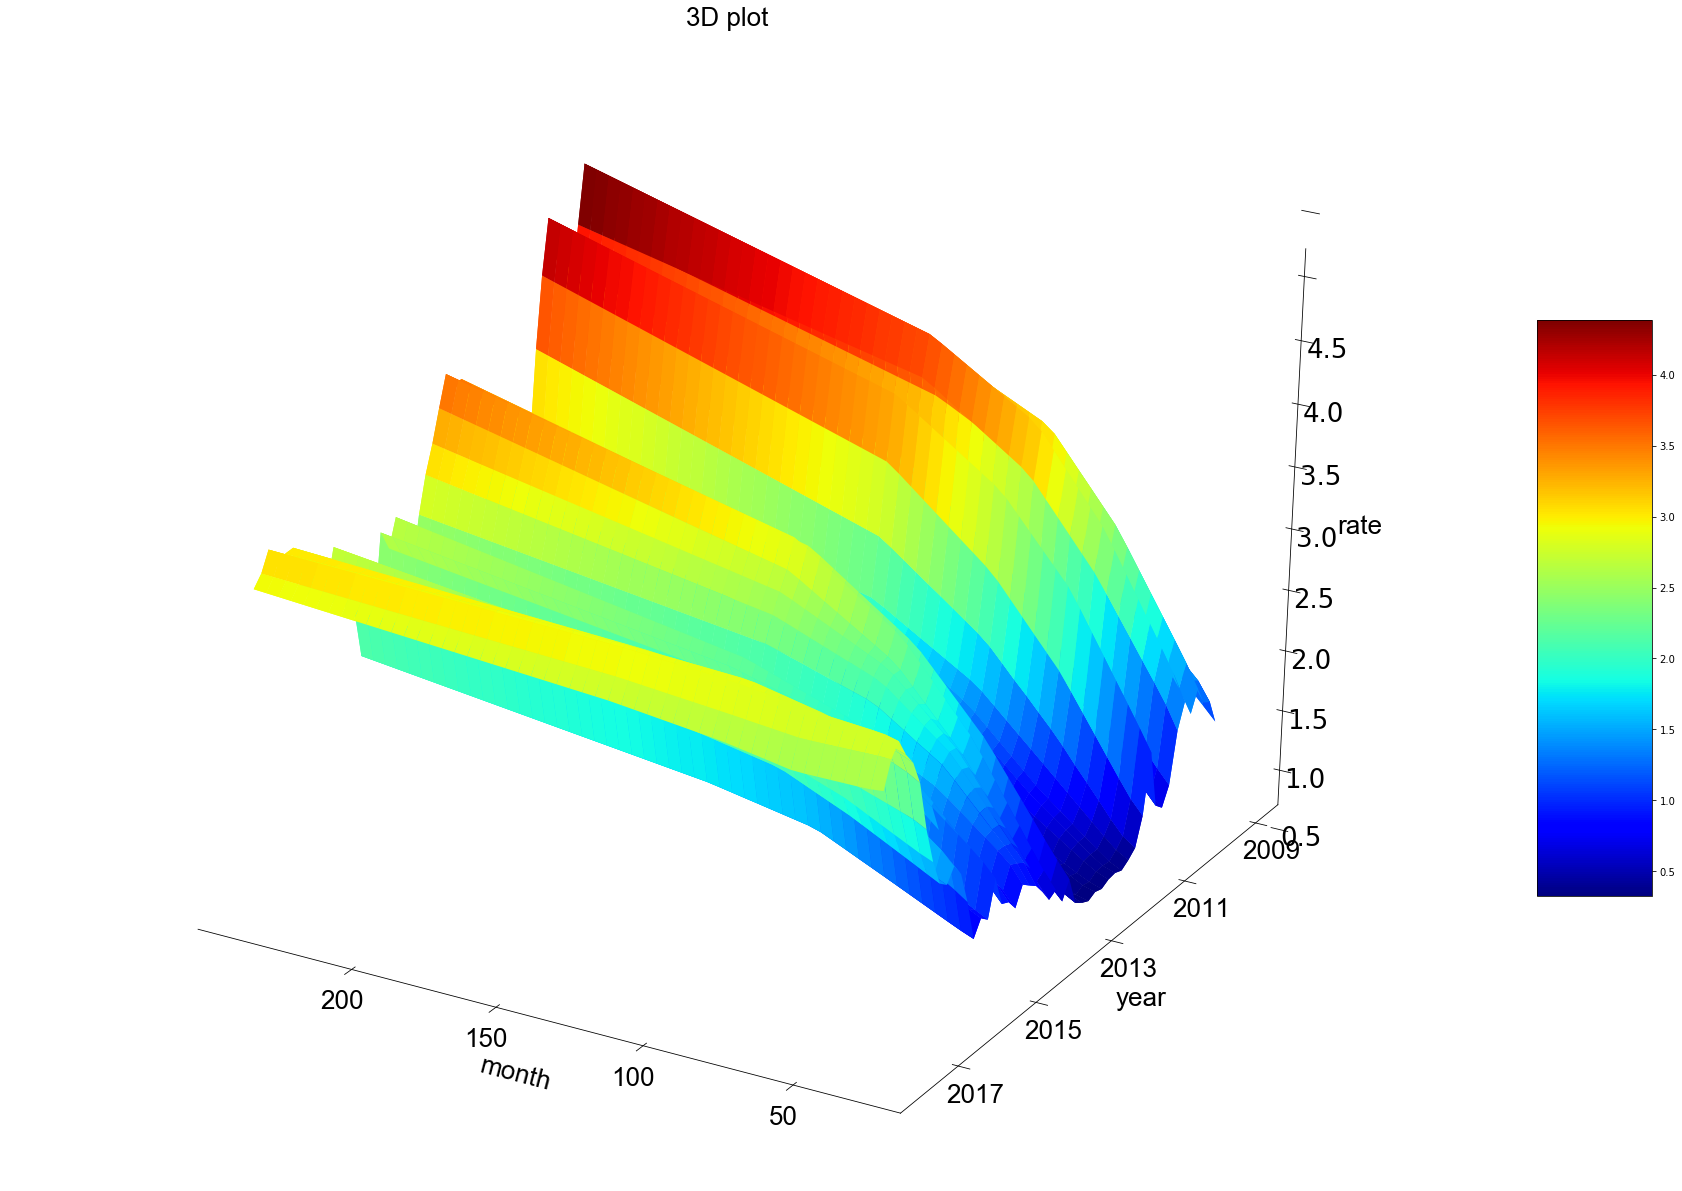

In [12]:
width=25
height=16

fig = plt.figure(figsize=(width,height))
ax = Axes3D(fig)
X = Xs
Y = Ys
Z = Zs
x = X.ravel()
y = Y.ravel()
z = Z.ravel()
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata(x, y, z, xi, yi,interp='linear')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=1, antialiased=True,alpha=1) 
fig.colorbar(surf, shrink=0.5, aspect=5)
#fig.tight_layout()

def init():
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=1, antialiased=True,alpha=1) 

    return fig,

def animate(i):
    ax.view_init(elev=32, azim=i)
    return fig,

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.invert_xaxis()
ax.invert_yaxis()
ax=std_plot(ax,'month','year','rate','3D plot',fontscale=4,
                xticklabel=np.array([str(i) for i in range(50,250,50)]),
               yticklabel = np.array([str(i) for i in range(2009,2019,2)]))

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=180,interval=20, blit=True)


anim.save('basic_animation1.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

# PCA
and ICA,CCA?

In [13]:
input_mx = select_arr[time_start:time_end]
input_table = select_table.iloc[time_start:time_end]

year_class = pd.DataFrame(np.concatenate((np.array(input_table.index).reshape(-1,1),np.array(['y'+i.split('-')[0] for i in 
                                input_table.index]).reshape(-1,1)),axis=1),columns=['sample','label'])
year_class = year_class.set_index('sample').astype('str')
month_class = pd.DataFrame(np.concatenate((np.array(input_table.index).reshape(-1,1),np.array(['m'+i.split('-')[1] for i in 
                                input_table.index]).reshape(-1,1)),axis=1),columns=['sample','label'])
month_class = month_class.set_index('sample').astype('str')


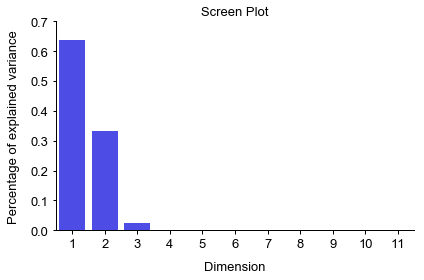

In [14]:
svd_solver = ['auto','full','arpack','randomized']
pca = PCA(svd_solver=svd_solver[0])
input_mx_ = StandardScaler().fit_transform(input_mx) #scale for columns
pca.fit(input_mx_)
#loadings = np.dot(np.diag(pca.singular_values_), pca.components_)
#how to reverse back: (X - np.mean(X, axis=0).reshape((1, -1))).dot(pca.components_.T)[0]

fig,ax=plt.subplots(figsize=(6,4))
plot_data = pd.DataFrame(np.concatenate((np.arange(1,pca.explained_variance_ratio_.shape[0]+1).reshape(-1,1).astype('int'),
                                         pca.explained_variance_ratio_.reshape(-1,1)),axis=1),columns=['Dimension','Percentage of explained variance'])
sns.barplot(data=plot_data,x='Dimension',y='Percentage of explained variance',color='blue',alpha=0.8)
ax=std_plot(ax,'Dimension','Percentage of explained variance',None,'Screen Plot',xticklabel=np.arange(1,pca.explained_variance_ratio_.shape[0]+1))
fig.tight_layout()
#embed_pdf_figure()


In [15]:
def zeroMean(dataMat):      
    meanVal=np.mean(dataMat,axis=0)     #按列求均值，即求各个特征的均值
    newData=dataMat-meanVal
    return newData,meanVal
 
def pca_own(dataMat,n=None):
    if n==None:
        n = dataMat.shape[1]
    newData,meanVal=zeroMean(dataMat)
    covMat=np.cov(newData,rowvar=0)    #求协方差矩阵,return ndarray；若rowvar非0，一列代表一个样本，为0，一行代表一个样本
    
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))#求特征值和特征向量,特征向量是按列放的，即一列代表一个特征向量
    eigValIndice=np.argsort(eigVals)            #对特征值从小到大排序
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   #最大的n个特征值的下标
    n_eigVect=eigVects[:,n_eigValIndice]        #最大的n个特征值对应的特征向量
    lowDDataMat=newData*n_eigVect               #低维特征空间的数据
    reconMat=(lowDDataMat*n_eigVect.T)+meanVal  #重构数据
    return lowDDataMat,reconMat,n_eigVect

In [16]:
_,pca_mx,loadings = pca_own(input_mx)

fig,ax=plt.subplots(figsize=(6,18))
#loadings_test = pca.components_*np.sqrt(pca.singular_values_)
sns.heatmap(input_mx_,ax=ax,vmin=-2, vmax=5, annot=True, fmt='.2f', cmap='vlag')

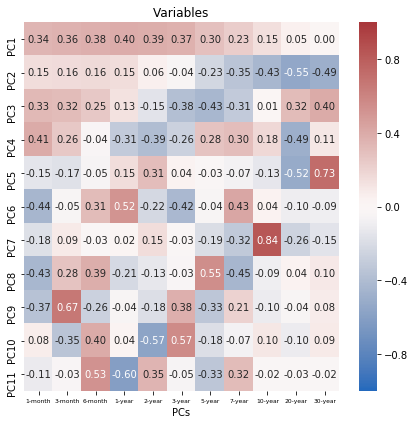

In [17]:
fig,ax=plt.subplots(figsize=(6,6))
#loadings_test = pca.components_*np.sqrt(pca.singular_values_)
sns.heatmap(loadings.T,ax=ax,vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='vlag')
ax.set_title('PCA loading matrix')
ax.set_xlabel('PCs')
ax.set_title('Variables')
ax.set_xticklabels(revise_columns,fontsize=6)
ax.set_yticklabels(np.array(['PC'+ str(i) for i in range(1,12)]))
fig.tight_layout()
#embed_pdf_figure()


In [18]:
def legendhandle(lists,porm=True,order=0):
    '''
        input: array,porm palette or marker
        palettesorder=0 dataset Category20c
        palettesorder=1 batch

        return a dic mapping levels of the hue variable to colors
        or return a dic mapping levels of the style variable to markers
        when use sns function, set palette=dic or markers=dic

    '''
    tableau10m = np.array([(114,158,206),(255,158,74),(103,191,92),(237,102,93),(173,139,201),
                       (168,120,110),(237,151,202),(162,162,162),(205,204,93),(109,204,218)])/255
    if porm == True:
        if order == 0:
            palette = np.array(Category20c[20]).reshape(4,-1).T.ravel() #
        if order == 1:
            palette = Pastel2[8]
        lists.sort()
        dic={}
        for i in range(len(lists)):
            dic[lists[i]]=palette[i]
        return dic
    else:
        markerlist1 = ['v','^','<','>'] #triangle_down triangle_up triangle_left triangle_left
        markerlist2 = ['P','o','X','s'] #plus (filled) circle x (filled) square
        #markerlist3 = ['$CPM$','$CPM_top$','$RLE$','$TMM$']
        markerlist3 = ['$f$','$g$','$h$','$l$']
        markerlist3.sort()
        if order == 0:
            markers = markerlist2
        if order == 1:
            markers = markerlist1
        if order == 2:
            markers = markerlist3
            
        lists.sort()
        dic={}
        for i in range(len(lists)):
            dic[lists[i]]=markers[i]
        return dic       


In [19]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
def PCA_plot_sns(ax,data,sampleclass,method = 'Origin'):
    #X = log_transfrom(data).T
    X = StandardScaler().fit_transform(data.T)
    if method=='Origin':
        X_pca=X
    if method == 'PCA':
        transform = PCA()
        X_pca = transform.fit_transform(X)
    elif method == 'tSNE':
        transform = TSNE()
        X_pca = transform.fit_transform(X)
   
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.index = data.columns
    plot_table = pd.concat((plot_table,sampleclass.loc[plot_table.index]),axis=1)
    plot_table.columns = ['dimension_1','dimension_2','class']
    classnum = np.unique(plot_table.iloc[:,2]).shape[0]
    
    #plot_table=plot_table.astype('float')
    #plot_table.iloc[:,2]  = plot_table.iloc[:,2].astype('str')
    #plot_table.iloc[:,0] = pd.to_numeric(plot_table.iloc[:,0])
    #plot_table.iloc[:,1] = pd.to_numeric(plot_table.iloc[:,1])

    sns.scatterplot(ax=ax,data=plot_table,x="dimension_1", y="dimension_2",markers=filled_markers,
                    palette=legendhandle(np.unique(plot_table['class'])), hue="class",style="class",s=30,linewidth=0.01)
    
    std_plot(ax,'Dimension 1','Dimension 2',None,
             title=method, legendtitle='class',legendsort=False
             ,xbins=6,ybins=6
            )
    legend = ax.legend(prop=fontlegend,
     bbox_to_anchor=(1.2,0.9),framealpha=0,labelspacing=0.24)
    ax.legend_.get_frame()._linewidth=0
    fig.tight_layout()
    fig.savefig('output/'+method+'_plot.eps')
    

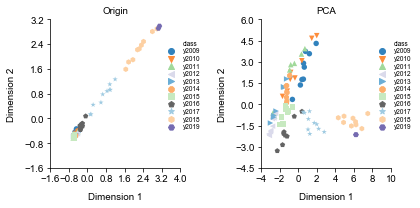

In [20]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
PCA_plot_sns(ax[0],input_table.T,year_class,'Origin')
PCA_plot_sns(ax[1],input_table.T,year_class,'PCA')

#embed_pdf_figure()

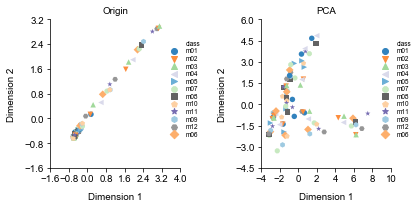

In [21]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
PCA_plot_sns(ax[0],input_table.T,month_class,'Origin')
PCA_plot_sns(ax[1],input_table.T,month_class,'PCA')

#embed_pdf_figure()

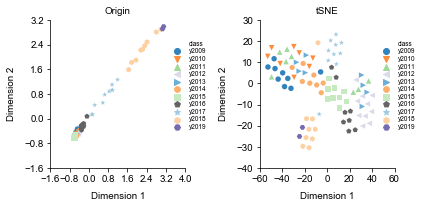

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
PCA_plot_sns(ax[0],input_table.T,year_class,'Origin')
PCA_plot_sns(ax[1],input_table.T,year_class,'tSNE')
fig.tight_layout()
#embed_pdf_figure()

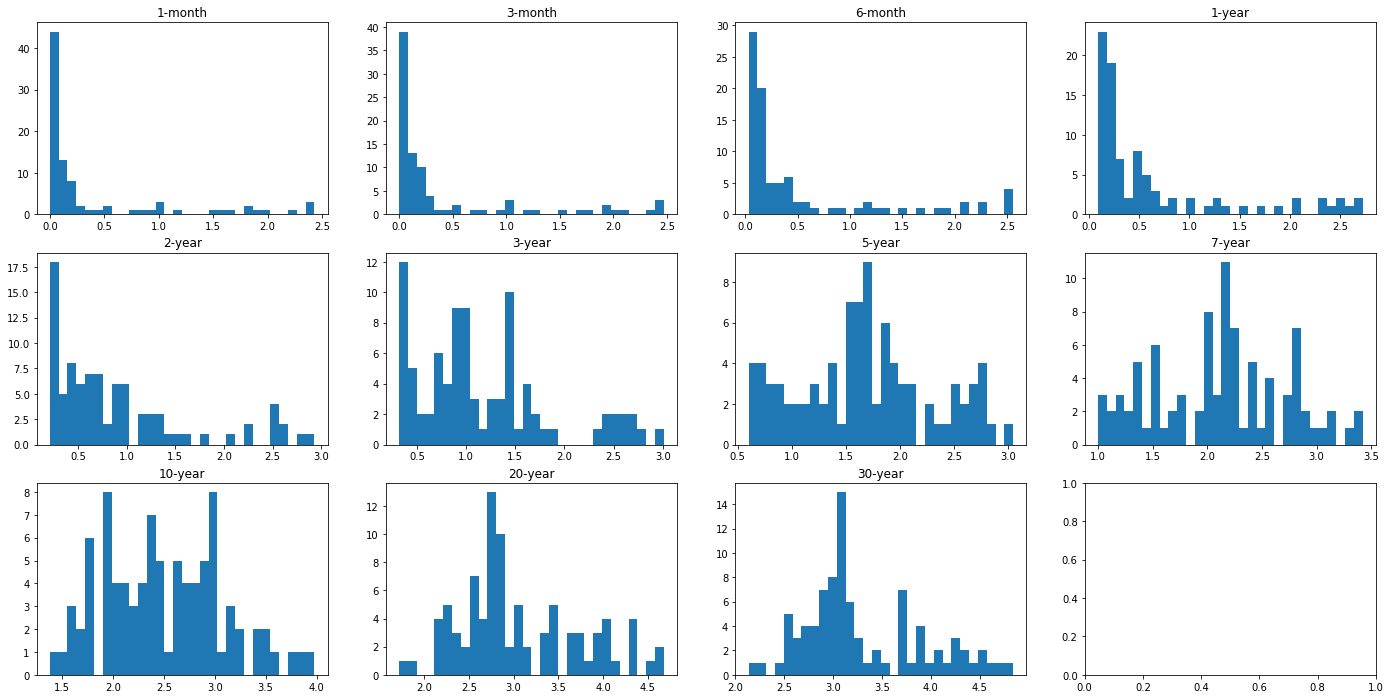

In [23]:
fig,ax = plt.subplots(3,4,figsize=(24,12))
for i in range(3):
    for j in range(4):
        if i*4+j<=10:
            ax[i,j].set_title(revise_columns[i*4+j])
            ax[i,j].hist(np.array(select_table.iloc[:,i*4+j]),bins=30)
#embed_pdf_figure()

In [24]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [25]:
metrics_sum = pd.DataFrame(index=revise_columns,
                          columns=['mean','std','skewness','kurtosis'])
for i in range(11):
    metrics_sum.iloc[i,0] = np.mean(select_table.iloc[:,i])
    metrics_sum.iloc[i,1] =np.std(select_table.iloc[:,i])
    metrics_sum.iloc[i,2] =skew(select_table.iloc[:,i])
    metrics_sum.iloc[i,3] =kurtosis(select_table.iloc[:,i])

In [26]:
metrics_sum

,mean,std,skewness,kurtosis
1-month,0.401236,0.654478,1.8917,2.29938
3-month,0.43809,0.680783,1.82375,2.00894
6-month,0.526404,0.71215,1.74099,1.71952
1-year,0.64618,0.735068,1.64643,1.45589
2-year,0.902135,0.706565,1.39284,0.99007
3-year,1.16674,0.677206,0.936489,0.210825
5-year,1.67764,0.614855,0.178631,-0.694048
7-year,2.11348,0.595711,0.0498472,-0.67209
10-year,2.49921,0.581905,0.331212,-0.459034
20-year,3.05966,0.672841,0.598109,-0.423001


select_table.columns = np.array(['time-'+i for i in np.array(select_table.columns)]).astype('str')
select_table.to_csv('data/select_table.txt')